In [2]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py
import bz2
import multiprocessing as mp


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors, KDTree

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import auc

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

# Extracting the point collection and the descriptors

In [17]:
with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)
    
with open('descriptors/new_complete_res5_4by5_descriptors.pickle','rb') as f:
    descriptors = pickle.load(f)
    
with open('descriptors/new_complete_RANSAC_res5_4by5_descriptors.pickle','rb') as f:
    ransac_descriptors = pickle.load(f)
    
with open('descriptors/chosen_arcore_res5_4by5_descriptors_complete.pickle','rb') as f:
    arcore_descriptors = pickle.load(f)
    
results_path = 'testing_results'

if not os.path.exists(results_path): os.mkdir(results_path)
    
obj_names = []

for obj_name, pointCloud, triangles in new_contiguous_point_collection:
    obj_names.append(obj_name)
    
contiguous_names_short = [
    'Recpt\'n',
    'Drvway',
    'Aprtmnt',
    'Wrkst\'n',
    'Kitchen',
    'Hallway',
    'Strwell',
]

contiguous_names = [
    'Reception',
    'Driveway',
    'Apartment',
    'Workstation',
    'Kitchen',
    'Hallway',
    'Stairwell',
]

colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:cyan",
    "tab:olive",
    "tab:gray",
    "tab:pink",
    "tab:brown"
]

#obj_names

# Performance Scores

# NN-matcher: HoloLens Results

In [5]:
# Hololens data

results_partials = [[],[]] 

raw_errors = []    
ransac_errors = []

for radius in np.arange(0.25, 5.1, 0.25):

    try:
        with bz2.BZ2File('testing_results/partial/ransac_{}_partial_scores_parallel_sample_points_2.pickle.bz2'.format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 

    except:
        print("Error getting Raw scores for",radius)
        continue

    partial_errors_pool = NN_matcher(partial_scores_pool)
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Ransac) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Ransac) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 
    
    ransac_errors.append([
        radius,
        partial_errors_pool
    ])
    
    results_partials[1].append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    try:
        with bz2.BZ2File('testing_results/partial/raw_{}_partial_scores.pickle.bz2'.format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 
            
    except:
        print("Error getting Raw scores for",radius)
        continue

    partial_errors_pool = NN_matcher(partial_scores_pool)
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Raw) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Raw) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 
    
    results_partials[0].append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    raw_errors.append([
        radius,
        partial_errors_pool
    ])
    
with open('testing_results/partial/results_partials_nn_matcher_1000.pickle', 'wb') as f:
    pickle.dump([results_partials, raw_errors, ransac_errors],f)


0.25 (Ransac) P1 Error Rate: 0.8909774436090225
   (Ransac) P2 Error Rate: 5.566 (± 1.549)
0.25 (Raw) P1 Error Rate: 0.8458646616541353
   (Raw) P2 Error Rate: 4.972 (± 1.552)
0.5 (Ransac) P1 Error Rate: 0.8473895582329317
   (Ransac) P2 Error Rate: 5.551 (± 2.716)
Error getting Raw scores for 0.5
0.75 (Ransac) P1 Error Rate: 0.7894736842105263
   (Ransac) P2 Error Rate: 4.154 (± 3.322)
0.75 (Raw) P1 Error Rate: 0.6917293233082706
   (Raw) P2 Error Rate: 3.748 (± 3.658)
1.0 (Ransac) P1 Error Rate: 0.6062124248496994
   (Ransac) P2 Error Rate: 2.916 (± 3.255)
Error getting Raw scores for 1.0
1.25 (Ransac) P1 Error Rate: 0.47368421052631576
   (Ransac) P2 Error Rate: 1.797 (± 2.289)
1.25 (Raw) P1 Error Rate: 0.05639097744360902
   (Raw) P2 Error Rate: 1.043 (± 1.182)
1.5 (Ransac) P1 Error Rate: 0.334
   (Ransac) P2 Error Rate: 1.529 (± 1.817)
Error getting Raw scores for 1.5
1.75 (Ransac) P1 Error Rate: 0.23308270676691728
   (Ransac) P2 Error Rate: 1.367 (± 1.266)
1.75 (Raw) P1 Error Ra

In [14]:
with open('testing_results/partial/results_partials_nn_matcher_1000.pickle', 'rb') as f:
    results_partials, raw_errors, ransac_errors = pickle.load(f)

per_space_score = []
perf_scores = []

#desired_r = [0.5, 1.0, 3.0]

for radius, partial_errors in ransac_errors:

    score_map = np.zeros((7,7))

    for score in partial_errors:
        score_map[int(score[0]),int(score[3])]+=1
        
    macro_score = f1_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    micro_score = f1_score(partial_errors[:,0],partial_errors[:,3],average='micro')
    mcc = matthews_corrcoef(partial_errors[:,0],partial_errors[:,3])
    ave_prec_score = precision_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    prec_score = precision_score(partial_errors[:,0],partial_errors[:,3],average=None)
    ave_recl_score = recall_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    recl_score = recall_score(partial_errors[:,0],partial_errors[:,3],average=None)
    
    per_space_score.append([
        f1_score(partial_errors[:,0],partial_errors[:,3],average=None),
        prec_score,
        recl_score
    ])
    
    perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc,
        (np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])
    
per_space_score = np.asarray(per_space_score)
perf_scores = np.asarray(perf_scores)

with open("testing_results/partial/" + "summary_results_1000.pickle",'wb') as f:
    pickle.dump([results_partials, per_space_score, perf_scores],f)
    

# NN-matcher: ARCore Results

In [42]:
# Results for ARCore dataset

arcore_results_partials = []

#raw_errors = []    
arcore_ransac_errors = []

with open('../../spatial-privacy/descriptors/chosen_arcore_res5_4by5_descriptors_complete.pickle','rb') as f:
    arcore_descriptors = pickle.load(f)

for radius in np.arange(0.25, 3.1, 0.25):

    try:
        with bz2.BZ2File("testing_results/nn_matcher_arcore/{}_partial_scores.pickle.bz2".format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 

    except:
        print("Error getting arcore scores for",radius)
        continue

    partial_errors_pool = ARcore_NNMatcher(partial_scores_pool, arcore_descriptors[:-1])
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Ransac) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Ransac) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 

    arcore_results_partials.append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    arcore_ransac_errors.append([
        radius,
        partial_errors_pool
    ])
    
with open("testing_results/nn_matcher_arcore/results_partials_nn_matcher.pickle", 'wb') as f:
    pickle.dump([arcore_results_partials, arcore_ransac_errors],f)

/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:386: RuntimeWarning: Mean of empty slice
  LA.norm(np.nanmean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),


0.25 (Ransac) P1 Error Rate: 0.8497983870967742
   (Ransac) P2 Error Rate: 2.102 (± 0.890)
0.5 (Ransac) P1 Error Rate: 0.8598790322580645
   (Ransac) P2 Error Rate: 7.348 (± 4.058)
0.75 (Ransac) P1 Error Rate: 0.8397177419354839
   (Ransac) P2 Error Rate: 7.695 (± 4.512)
1.0 (Ransac) P1 Error Rate: 0.8316532258064516
   (Ransac) P2 Error Rate: 6.878 (± 4.677)
1.25 (Ransac) P1 Error Rate: 0.7993951612903226
   (Ransac) P2 Error Rate: 5.384 (± 4.314)
1.5 (Ransac) P1 Error Rate: 0.7752016129032258
   (Ransac) P2 Error Rate: 4.820 (± 4.324)
1.75 (Ransac) P1 Error Rate: 0.7449596774193549
   (Ransac) P2 Error Rate: 4.680 (± 4.463)
2.0 (Ransac) P1 Error Rate: 0.7258064516129032
   (Ransac) P2 Error Rate: 4.437 (± 4.405)
2.25 (Ransac) P1 Error Rate: 0.7217741935483871
   (Ransac) P2 Error Rate: 4.490 (± 4.538)
2.5 (Ransac) P1 Error Rate: 0.7086693548387096
   (Ransac) P2 Error Rate: 3.947 (± 4.204)
2.75 (Ransac) P1 Error Rate: 0.7147177419354839
   (Ransac) P2 Error Rate: 4.092 (± 4.212)
3.0 

In [53]:
arcore_nn_per_space_score = []
arcore_nn_perf_scores = []

#desired_r = [0.5, 1.0, 3.0]

for radius, partial_errors in arcore_ransac_errors:
    
    partial_errors = np.asarray(partial_errors[:,[0,3]], dtype=int)

    score_map = np.zeros((7,7))

    for score in partial_errors:
        score_map[int(score[0]),int(score[1])]+=1
        
    macro_score = f1_score(partial_errors[:,0],partial_errors[:,1],average='macro')
    micro_score = f1_score(partial_errors[:,0],partial_errors[:,1],average='micro')
    mcc = matthews_corrcoef(partial_errors[:,0],partial_errors[:,1])
    ave_prec_score = precision_score(partial_errors[:,0],partial_errors[:,1],average='macro')
    prec_score = precision_score(partial_errors[:,0],partial_errors[:,1],average=None)
    ave_recl_score = recall_score(partial_errors[:,0],partial_errors[:,1],average='macro')
    recl_score = recall_score(partial_errors[:,0],partial_errors[:,1],average=None)

    arcore_nn_per_space_score.append([
        f1_score(partial_errors[:,0],partial_errors[:,1],average=None),
        prec_score,
        recl_score
    ])

    arcore_nn_perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc,
        (np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])

    
arcore_nn_per_space_score = np.asarray(arcore_nn_per_space_score)
arcore_nn_perf_scores = np.asarray(arcore_nn_perf_scores)

with open("testing_results/nn_matcher_arcore/" + "summary_results.pickle",'wb') as f:
    pickle.dump([arcore_results_partials, arcore_nn_per_space_score, arcore_nn_perf_scores],f)
    

/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# PointnetVLAD: HoloLens results

In [11]:
RESULTS_FOLDER="testing_results/pointnetvlad_prod/"
if not os.path.exists(RESULTS_FOLDER): os.mkdir(RESULTS_FOLDER)   

pickle_file = 'partial_results_updated_refs.pickle'

try:
    with open(RESULTS_FOLDER + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No results.")
    
pointnetvlad_results = []
pointnetvlad_per_space_score = []
pointnetvlad_perf_scores= []

for radius, recall, intra_dist, test_recall in results_pickle:
    
    pointnetvlad_results.append([
        radius,
        recall[0],
        intra_dist[0]
    ])
    
    count_diff = 0

    errors_pool = []
    
    for m, n, top1_obj_cands in test_recall:
        
        if len(errors_pool) == 0:
            errors_pool = top1_obj_cands
        else:
            errors_pool = np.concatenate((errors_pool,top1_obj_cands), axis = 0)
            
        #print("  ",m,n,len(top1_obj_cands),len(errors_pool))
        
    macro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='macro')    
    micro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='micro')
    mcc = matthews_corrcoef(errors_pool[:,0],errors_pool[:,1])
    ave_prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average=None)
    ave_recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average=None)
    
    pointnetvlad_per_space_score.append([
        f1_score(errors_pool[:,0],errors_pool[:,1],average=None),
        prec_score,
        recl_score
    ])
    
    pointnetvlad_perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc
        #(np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])

    1 - count_diff/len(test_recall)
    
    
pointnetvlad_results = np.asarray(pointnetvlad_results)
pointnetvlad_per_space_score = np.asarray(pointnetvlad_per_space_score)
pointnetvlad_perf_scores = np.asarray(pointnetvlad_perf_scores)

with open("testing_results/pointnetvlad_prod/" + "summary_results.pickle",'wb') as f:
    pickle.dump([pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores],f)
    


/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
RESULTS_FOLDER="testing_results/pointnetvlad_prod_2/"
if not os.path.exists(RESULTS_FOLDER): os.mkdir(RESULTS_FOLDER)   
    
pickle_file = 'partial_results_updated_refs_2_0.5.pickle'

try:
    with open(RESULTS_FOLDER + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No results.")
    
pointnetvlad_results = []
pointnetvlad_per_space_score = []
pointnetvlad_perf_scores= []

for radius, recall, intra_dist, test_recall in results_pickle:
    
    pointnetvlad_results.append([
        radius,
        recall[0],
        intra_dist[0]
    ])
    
    count_diff = 0

    errors_pool = []
    
    for m, n, top1_obj_cands in test_recall:
        
        """
        if len(errors_pool) == 0:
            errors_pool = top1_obj_cands
        else:
            errors_pool = np.concatenate((errors_pool,top1_obj_cands), axis = 0)
        """
        
        for original_vertex, orig_label, cand_label in top1_obj_cands:
            
            #print(radius, m ,n, original_vertex, orig_label, cand_label)

            per_obj_label = []
            per_obj_label.append(orig_label)
            per_obj_label.append(cand_label)
            per_obj_label.append(original_vertex[0])
            per_obj_label.append(original_vertex[1])
            per_obj_label.append(original_vertex[2])
            errors_pool.append(per_obj_label)
            
        #print("  ",m,n,len(top1_obj_cands),len(errors_pool))
    errors_pool = np.asarray(errors_pool)
    
    #print(errors_pool)
    
    macro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='macro')    
    micro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='micro')
    mcc = matthews_corrcoef(errors_pool[:,0],errors_pool[:,1])
    ave_prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average=None)
    ave_recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average=None)
    
    pointnetvlad_per_space_score.append([
        f1_score(errors_pool[:,0],errors_pool[:,1],average=None),
        prec_score,
        recl_score
    ])
    
    pointnetvlad_perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc
        #(np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])

    1 - count_diff/len(test_recall)
    
pointnetvlad_results = np.asarray(pointnetvlad_results)
pointnetvlad_per_space_score = np.asarray(pointnetvlad_per_space_score)
pointnetvlad_perf_scores = np.asarray(pointnetvlad_perf_scores)

with open("testing_results/pointnetvlad_prod/" + "summary_results_updated.pickle",'wb') as f:
    pickle.dump([pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores],f)
    

# PointnetVLAD: ARCore results

In [92]:
#ARCORE REsults

RESULTS_FOLDER="testing_results/pointnetvlad/"
    
pickle_file = 'arcore_partial_results.pickle'

try:
    with open(RESULTS_FOLDER + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No results.")
    
arcore_pv_results = []
arcore_pv_per_space_score = []
arcore_pv_perf_scores = []

for radius, recall, intra_dist, test_recall in results_pickle:
    
    arcore_pv_results.append([
        radius,
        recall[0],
        intra_dist[0]
    ])
    
    count_diff = 0

    errors_pool = []
    
    for m, n, top1_obj_cands in test_recall:
        if len(errors_pool) == 0:
            errors_pool = top1_obj_cands
        else:
            errors_pool = np.concatenate((errors_pool,top1_obj_cands), axis = 0)
            
        #print("  ",m,n,len(top1_obj_cands),len(errors_pool))
        
    macro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='macro')    
    micro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='micro')
    mcc = matthews_corrcoef(errors_pool[:,0],errors_pool[:,1])
    ave_prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average=None)
    ave_recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average=None)
    
    arcore_pv_per_space_score.append([
        f1_score(errors_pool[:,0],errors_pool[:,1],average=None),
        prec_score,
        recl_score
    ])
    
    arcore_pv_perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc
        #(np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])

    1 - count_diff/len(test_recall)
    
    
arcore_pv_results = np.asarray(arcore_pv_results)
arcore_pv_per_space_score = np.asarray(arcore_pv_per_space_score)
arcore_pv_perf_scores = np.asarray(arcore_pv_perf_scores)

with open("testing_results/pointnetvlad/" + "arcore_summary_results.pickle",'wb') as f:
    pickle.dump([arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores],f)
    

/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Plotting F1 scores

Hololens, NN [0.14304344 0.39144113 0.66452766 0.80949408 0.87243358 0.89924443]
Hololens, PV [0.06667366 0.15353992 0.31465453 0.82321138 0.93209272 0.96580331]
ARCore, NN [0.11316414 0.15959665 0.22057438 0.26365282 0.28101654 0.28372453]
ARCore, PV [0.03464725 0.08717726 0.19262745 0.25962154 0.30915    0.31838326]


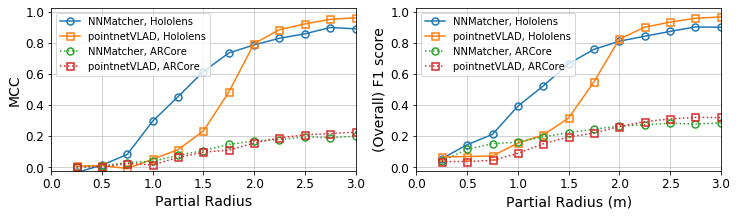

In [15]:
# Using F1 scores

fig=plt.figure(figsize=(12, 3))

with open("testing_results/pointnetvlad_arcore/" + "arcore_summary_results.pickle",'rb') as f:
    arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores = pickle.load(f)
    
with open("testing_results/pointnetvlad_prod/" + "summary_results.pickle",'rb') as f:
    pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores = pickle.load(f)
    
with open("testing_results/partial/" + "summary_results_1000.pickle",'rb') as f:
    nn_results_partials, nn_per_space_score, nn_perf_scores = pickle.load(f)
    
with open("testing_results/nn_matcher_arcore/" + "summary_results.pickle",'rb') as f:
    arcore_results_partials, arcore_nn_per_space_score, arcore_nn_perf_scores = pickle.load(f)

    
HololensNN = nn_perf_scores
HololensPV = pointnetvlad_perf_scores
ARCoreNN = arcore_nn_perf_scores
ARCorePV = arcore_pv_perf_scores

linewidth = 2.0
markersize = 8.0

ax1 = fig.add_subplot(121)#, sharex = ax2) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,3.0)
ax1.set_ylabel("MCC", fontsize = 14);
ax1.set_xlabel("Partial Radius", fontsize = 14);

ax1.set_xticklabels(np.arange(0,3.1,0.5),fontsize=12)
ax1.set_yticks(np.arange(0,1.1,0.2))
ax1.set_yticklabels(np.around(np.arange(0,1.1,0.2), decimals = 1),fontsize=12)

markersize = 7
linewidth = 1.5

ax1.plot(
    HololensNN[:,0],
    HololensNN[:,3], 
    linewidth = linewidth, 
    marker = 'o',fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NNMatcher, Hololens"
)
ax1.plot(
    HololensPV[:,0],
    HololensPV[:,3],
    '-s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetVLAD, Hololens"
)

ax1.plot(
    ARCoreNN[:,0],
    ARCoreNN[:,3], 
    ':o',linewidth = linewidth, 
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NNMatcher, ARCore"
)

ax1.plot(
    ARCorePV[:,0],
    ARCorePV[:,3],
    ':s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetVLAD, ARCore"
)

ax1.legend(loc = "best", ncol = 1, fontsize = 10);# bbox_to_anchor=(1.1, 1.5));

ax2 = fig.add_subplot(122)#, sharex = ax1) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.025,1.025)
ax2.set_xlim(0,3)

ax2.set_ylabel("(Overall) F1 score", fontsize = 14);
ax2.set_xlabel("Partial Radius (m)", fontsize = 14);

ax2.set_xticklabels(np.arange(0,3.1,0.5),fontsize=12)
ax2.set_yticks(np.arange(0,1.1,0.2))
ax2.set_yticklabels(np.around(np.arange(0,1.1,0.2), decimals = 1),fontsize=12)

#plt.minorticks_on()

ax2.plot(
    HololensNN[:,0],
    HololensNN[:,1], 
    linewidth = linewidth, 
    marker = 'o',fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NNMatcher, Hololens"
)
ax2.plot(
    HololensPV[:,0],
    HololensPV[:,1],
    '-s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetVLAD, Hololens"
)
ax2.plot(
    ARCoreNN[:,0],
    ARCoreNN[:,1], 
    ':o',
    linewidth = linewidth, 
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NNMatcher, ARCore"
)
ax2.plot(
    ARCorePV[:,0],
    ARCorePV[:,1],
    ':s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetVLAD, ARCore"
)

ax2.legend(loc = "best", ncol = 1, fontsize = 10);#, bbox_to_anchor=(1.1, 1.5));

#plt.title("NN-matcher")

#plt.savefig('plots/overall-f1-partials-radius-with-arcore.png', format='png', dpi=300,bbox_inches = 'tight')
#plt.savefig('plots/overall-f1-partials-radius-with-arcore.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
print('Hololens, NN', HololensNN[1:12:2,1])
print('Hololens, PV', HololensPV[1:12:2,1])
print('ARCore, NN', ARCoreNN[1:12:2,1])
print('ARCore, PV', ARCorePV[1:12:2,1])


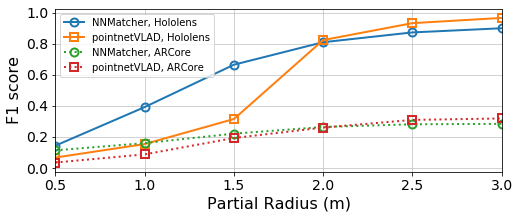

In [356]:
# Using F1 scores

fig=plt.figure(figsize=(8, 3))

with open("testing_results/pointnetvlad_arcore/" + "arcore_summary_results.pickle",'rb') as f:
    arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores = pickle.load(f)
    
with open("testing_results/pointnetvlad_prod/" + "summary_results_updated.pickle",'rb') as f:
    pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores = pickle.load(f)
    
with open("testing_results/partial/" + "summary_results_1000.pickle",'rb') as f:
    nn_results_partials, nn_per_space_score, nn_perf_scores = pickle.load(f)
    
with open("testing_results/nn_matcher_arcore/" + "summary_results.pickle",'rb') as f:
    arcore_results_partials, arcore_nn_per_space_score, arcore_nn_perf_scores = pickle.load(f)

    
HololensNN = nn_perf_scores
HololensPV = pointnetvlad_perf_scores
ARCoreNN = arcore_nn_perf_scores
ARCorePV = arcore_pv_perf_scores

linewidth = 2.0
markersize = 8.0

ax2 = fig.add_subplot(111) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.025,1.025)
ax2.set_xlim(0.5,3)

ax2.set_ylabel("F1 score", fontsize = 16);
ax2.set_xlabel("Partial Radius (m)", fontsize = 16);

ax2.set_xticklabels(np.arange(0.5,3.1,0.5),fontsize=14)
ax2.set_yticks(np.arange(0,1.1,0.2))
ax2.set_yticklabels(np.around(np.arange(0,1.1,0.2), decimals = 1),fontsize=14)

#plt.minorticks_on()

ax2.plot(
    HololensNN[1::2,0],
    HololensNN[1::2,1], 
    linewidth = linewidth, 
    marker = 'o',fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NNMatcher, Hololens"
)
ax2.plot(
    HololensPV[1::2,0],
    HololensPV[1::2,1],
    '-s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetVLAD, Hololens"
)
ax2.plot(
    ARCoreNN[1::2,0],
    ARCoreNN[1::2,1], 
    ':o',
    linewidth = linewidth, 
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NNMatcher, ARCore"
)
ax2.plot(
    ARCorePV[1::2,0],
    ARCorePV[1::2,1],
    ':s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetVLAD, ARCore"
)

ax2.legend(loc = "best", ncol = 1, fontsize = 10);#, bbox_to_anchor=(1.1, 1.5));

#plt.title("NN-matcher")

# Per-space F1 score (Heatmap)

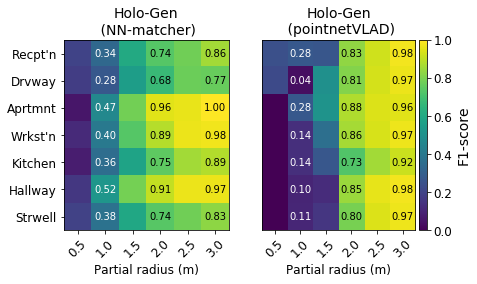

In [16]:
fig = plt.figure(figsize=(6.5,3.5))

with open("testing_results/pointnetvlad_arcore/" + "arcore_summary_results.pickle",'rb') as f:
    arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores = pickle.load(f)
    
with open("testing_results/pointnetvlad_prod/" + "summary_results.pickle",'rb') as f:
    pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores = pickle.load(f)
    
with open("testing_results/partial/" + "summary_results_1000.pickle",'rb') as f:
    nn_results_partials, nn_per_space_score, nn_perf_scores = pickle.load(f)
    
with open("testing_results/nn_matcher_arcore/" + "summary_results.pickle",'rb') as f:
    arcore_results_partials, arcore_nn_per_space_score, arcore_nn_perf_scores = pickle.load(f)

#fig3 = plt.figure(constrained_layout=True)
#gs = fig3.add_gridspec(3, 3)
ax2 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
#fig.figsize(8,3.5)

im2 = ax2.imshow(
    nn_per_space_score[1:12:2,0].T,
    vmin=0.0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

for i, per_radius in enumerate(nn_per_space_score[3:12:4,0]):
    
    for j, value in enumerate(per_radius):
        
        color = 'black'
        
        if i == 0: color = 'white'

        ax2.text(
            i*2+1, j,
            ha="center", va="center",
            s = "{:.2f}".format(value),
            fontsize = 10,
            color = color
        )

ax2.set_title("Holo-Gen\n (NN-matcher)", fontsize = 14)
ax2.set_xticks(np.arange(6))
ax2.set_xticklabels(nn_perf_scores[1:12:2,0], rotation=45, fontsize = 12)
ax2.set_xlabel("Partial radius (m)",fontsize = 12)
ax2.set_yticks(np.arange(len(contiguous_names)))
ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
#ax2.set_yticks([])
#ax2.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

im3 = ax3.imshow(
    pointnetvlad_per_space_score[1:12:2,0].T,
    vmin=0.0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

for i, per_radius in enumerate(pointnetvlad_per_space_score[3:12:4,0]):
    
    for j, value in enumerate(per_radius):
        
        color = 'black'
        
        if i == 0: color = 'white'

        ax3.text(
            i*2+1, j,
            ha="center", va="center",
            s = "{:.2f}".format(value),
            fontsize = 10,
            color = color
        )

ax3.set_title("Holo-Gen\n (pointnetVLAD)", fontsize = 14)
ax3.set_xticks(np.arange(6))
ax3.set_xticklabels(pointnetvlad_perf_scores[1:12:2,0], rotation=45, fontsize = 12)
ax3.set_xlabel("Partial radius (m)",fontsize = 12)
ax3.set_yticks([])
ax3.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

# Create divider for existing axes instance
divider3 = make_axes_locatable(ax3)
# Append axes to the right of ax3, with 20% width of ax3
cax3 = divider3.append_axes("right", size="5%", pad=0.05)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar3 = plt.colorbar(im3, cax=cax3, ticks=np.arange(0.0,1.1,0.2), format="%.1f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)

cbar3.ax.set_yticklabels(
    np.around(np.arange(0.0,1.1,0.2),decimals = 2),
#    np.concatenate((['≤ 0.4'],np.around(np.arange(0.5,1.1,0.1), decimals = 2))),
    fontsize = 12);
cbar3.ax.set_ylabel("F1-score", fontsize = 14)
"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()

plt.savefig('properties/nnmatcher-f1-scores.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/nnmatcher-f1-scores.png', format='png', dpi=300,bbox_inches = 'tight')


"\nplt.savefig('properties/arcore-f1-scores-annotated.pdf', format='pdf', dpi=300,bbox_inches = 'tight')\nplt.savefig('properties/arcore-f1-scores-annotated.png', format='png', dpi=300,bbox_inches = 'tight')\n"

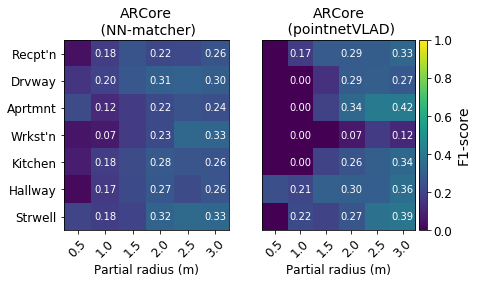

In [13]:
fig = plt.figure(figsize=(6.5,3.5))

with open("testing_results/pointnetvlad_arcore/" + "arcore_summary_results.pickle",'rb') as f:
    arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores = pickle.load(f)
    
with open("testing_results/pointnetvlad_prod/" + "summary_results.pickle",'rb') as f:
    pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores = pickle.load(f)
    
with open("testing_results/partial/" + "summary_results_1000.pickle",'rb') as f:
    nn_results_partials, nn_per_space_score, nn_perf_scores = pickle.load(f)
    
with open("testing_results/nn_matcher_arcore/" + "summary_results.pickle",'rb') as f:
    arcore_results_partials, arcore_nn_per_space_score, arcore_nn_perf_scores = pickle.load(f)

#fig3 = plt.figure(constrained_layout=True)
#gs = fig3.add_gridspec(3, 3)
ax2 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
#fig.figsize(8,3.5)

im2 = ax2.imshow(
    arcore_nn_per_space_score[1:12:2,0].T,
    vmin=0.0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

for i, per_radius in enumerate(arcore_nn_per_space_score[3:12:4,0]):
    
    for j, value in enumerate(per_radius):
        
        color = 'white'
        
        if i == 0: color = 'white'

        ax2.text(
            i*2+1, j,
            ha="center", va="center",
            s = "{:.2f}".format(value),
            fontsize = 10,
            color = color
        )

ax2.set_title("ARCore\n (NN-matcher)", fontsize = 14)
ax2.set_xticks(np.arange(6))
ax2.set_xticklabels(arcore_nn_perf_scores[1:12:2,0], rotation=45, fontsize = 12)
ax2.set_xlabel("Partial radius (m)",fontsize = 12)
ax2.set_yticks(np.arange(len(contiguous_names)))
ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
#ax2.set_yticks([])
#ax2.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

im3 = ax3.imshow(
    arcore_pv_per_space_score[1:12:2,0].T,
    vmin=0.0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

for i, per_radius in enumerate(arcore_pv_per_space_score[3:12:4,0]):
    
    for j, value in enumerate(per_radius):
        
        color = 'white'
        
        if i == 0: color = 'white'

        ax3.text(
            i*2+1, j,
            ha="center", va="center",
            s = "{:.2f}".format(value),
            fontsize = 10,
            color = color
        )

ax3.set_title("ARCore\n (pointnetVLAD)", fontsize = 14)
ax3.set_xticks(np.arange(6))
ax3.set_xticklabels(arcore_pv_perf_scores[1:12:2,0], rotation=45, fontsize = 12)
ax3.set_xlabel("Partial radius (m)",fontsize = 12)
ax3.set_yticks([])
ax3.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

# Create divider for existing axes instance
divider3 = make_axes_locatable(ax3)
# Append axes to the right of ax3, with 20% width of ax3
cax3 = divider3.append_axes("right", size="5%", pad=0.05)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar3 = plt.colorbar(im3, cax=cax3, ticks=np.arange(0.0,1.1,0.2), format="%.1f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)

cbar3.ax.set_yticklabels(
    np.around(np.arange(0.0,1.1,0.2),decimals = 2),
#    np.concatenate((['≤ 0.4'],np.around(np.arange(0.5,1.1,0.1), decimals = 2))),
    fontsize = 12);
cbar3.ax.set_ylabel("F1-score", fontsize = 14)
"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()

"""
plt.savefig('properties/arcore-f1-scores-annotated.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/arcore-f1-scores-annotated.png', format='png', dpi=300,bbox_inches = 'tight')
"""